In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii
import astropy.constants as ac
import astropy.units as u
%matplotlib inline

### RV data for planet

In [2]:
# Planet HD 189733
rv_data = astropy.io.ascii.read("UID_0098505_RVC_002.tbl.txt")

### Fitting RV data for planet and finding the period with the highest power 
#### (The period of our planet)

The period with the highest power is:  2.218636200341774  day


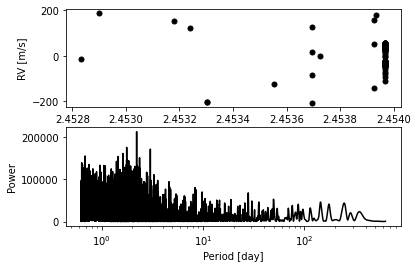

In [3]:
import scipy.signal as signal
x = rv_data["JD"]
y = rv_data["Radial_Velocity"]
e = rv_data["Radial_Velocity_Uncertainty"]

# Finding the periodicity of the planet 

nout = 1e5
f = np.linspace(0.01, 10.0, int(nout)) # frequency (1/day) at which power is calculated. 
#pgram = signal.lombscargle(x, y, f, normalize=True)
pgram = signal.lombscargle(x, y, f)

plt.subplot(2, 1, 1)
plt.errorbar(x, y , e, ms=5, marker="o", ls="none", color="black")
plt.xlabel("Time [BJD]")
plt.ylabel("RV [m/s]")
plt.subplot(2, 1, 2)
plt.plot(2 * np.pi / f, pgram, color="black")
plt.xscale("log")
plt.xlabel("Period [day]")
plt.ylabel("Power")

# Finding the period for the highest power
print("The period with the highest power is: ", 2 * np.pi / f[np.where(pgram == np.max(pgram))][0], " day")

### Plotting Best-fit Model

/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/radvel/gp.py:33: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  Try installing celerite using 'pip install celerite'", ImportWarning)


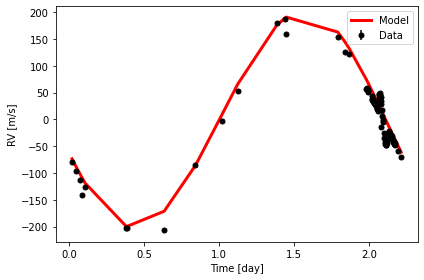

In [4]:
# Time data
t = rv_data["JD"].data

#Calculating the model given the parameters

# Model parameters found using EXOFAST and the period can also be found above for the period at the highest power

if False:
    import JW_lib
    orbital_solution = [2.21863, 2453935.531264, 0.019434, 83.300, 202.283082]
    rv = JW_lib.RadialVelocity(orbital_solution)
    # The parameters are period, time at periastron, eccentricity, argument of periastron, RV semi-amplitude

    # Calculate model RVs
    rvs = rv.rv_drive(t)
else:
    import radvel
    orbital_solution = [2.21863, 2453935.531264, 0.019434, 83.300 / 360.0 * 2 * np.pi, 202.283082]
    rvs = radvel.kepler.rv_drive(t, orbital_solution, use_c_kepler_solver=False)

per = 2.21863

%matplotlib inline

# Fold data and plot model against data

ind = np.argsort(t % per)

# Plotting data
plt.errorbar(rv_data["JD"] % per, rv_data["Radial_Velocity"], rv_data["Radial_Velocity_Uncertainty"], 
             color="black", ms=5, marker="o", ls="none", label="Data")

# Plotting model
plt.plot((t % per)[ind], rvs[ind], "r-", label="Model", lw=3)

# Labels and format
plt.legend()
plt.xlabel("Time [day]")
plt.ylabel("RV [m/s]")
plt.tight_layout()



### Finding Semi-Amplitude K

In [5]:
# Max RV value in data set with its corresponding uncertainty
max_rv = np.max(rv_data["Radial_Velocity"])
max_index = np.argmax(rv_data["Radial_Velocity"])
max_rv_uncert = rv_data["Radial_Velocity_Uncertainty"][max_index]

# Min RV value in data set with its corresponding uncertainty
min_rv = np.min(rv_data["Radial_Velocity"])
min_index = np.argmin(rv_data["Radial_Velocity"])
min_rv_uncert = rv_data["Radial_Velocity_Uncertainty"][min_index]

print('Maximum radial velocity:',max_rv, ' +/- ', max_rv_uncert, 'm/s')
print('Minimum radial velocity:',min_rv, ' +/- ', min_rv_uncert, 'm/s')

# Finding the Semi-amplitude
K_val = (max_rv + np.abs(min_rv)) / 2
print('Radial Velocity Semi-amplitude K:', K_val, 'm/s')

# K val from EXOFAST was 202.28 m/s

Maximum radial velocity: 186.717  +/-  1.48 m/s
Minimum radial velocity: -206.994  +/-  1.302 m/s
Radial Velocity Semi-amplitude K: 196.8555 m/s


### Finding the mass of the planet 
Will use the equation
#### $K = \frac{m_p}{m_\ast}\cdot\sqrt{\frac{Gm_\ast}{a}}\cdot\sin i$


#### $m_p\sin i = K \cdot m_\ast \cdot \sqrt{\frac{a}{Gm_\ast}}$


In [6]:
# Values needed for calculation
# Mass of star in Msun
m_star = 0.84

#Semi-major axis in au, found from EXOFAST
sm_axis = 0.0314

#Calculating planet mass
mp_kg = K_val * u.meter / u.second * (m_star * ac.M_sun) * np.sqrt((sm_axis*ac.au) / ac.G / (m_star * ac.M_sun)) 

# COnverting into jupiter masses
M_p = mp_kg / (ac.M_jup)

print('Planet mass:', M_p,'Jupiter Masses')

print('Planet mass with EXOFAST K value: 1.1488 Jupiter Masses')

Planet mass: 1.1244498801116423 Jupiter Masses
Planet mass with EXOFAST K value: 1.1488 Jupiter Masses


### Error propogation for K and mass

### $ \sigma_K = \frac{\sqrt{\sigma_\max^2 +\sigma_\min^2}}{2}$

In [7]:
# Uncertainty for K

K_uncert = ((max_rv_uncert)**2 + (min_rv_uncert)**2)**(1/2) /2

print('Uncertainty for K:', K_uncert)

Uncertainty for K: 0.9855967735336799


### Error Propogation for the Planet Mass
Includes the uncertainties of the stellar mass and semi-major axis of planet

### $ \sigma_{Mp} = \frac{1}{2} \sqrt{\frac{\frac{K^2M\sigma_a^2}{a}+\frac{K^2a\sigma_M^2}{M}+4Ma\sigma_K^2}{G}}$

#### Where M is the stellar mass

In [10]:
# Uncertainty for the mass of the planet will be a result of the uncertainty of K times the same constants

# Uncertainty value for star mass from TICv8 source
mstar_uncert = 0.02015

# Uncertainty value for semi-major axis of planet from (Rosenthal et al. 2021) source
a_uncert = 0.00036


# Previous Method
#Mp_uncert = K_uncert * u.meter / u.second * (m_star * ac.M_sun) * np.sqrt((sm_axis*ac.au) / ac.G / (m_star * ac.M_sun)) / ac.M_jup
#print(Mp_uncert)

# Improved Method

Mp_uncert_new = np.sqrt(((K_val * u.meter / u.second)**2 *(m_star * ac.M_sun)*(a_uncert * ac.au)**2 /(sm_axis * ac.au) + (K_val* u.meter / u.second)**2 * (mstar_uncert * ac.M_sun)**2 *(sm_axis * ac.au) / (m_star * ac.M_sun) +4*(m_star * ac.M_sun)*(sm_axis * ac.au) * (K_uncert * u.meter / u.second)**2)/ac.G)/2/ac.M_jup

print('Uncertainty of Planet Mass:', Mp_uncert_new)

Uncertainty of Planet Mass: 0.01597295260640268


### Final results

In [9]:
print('Planet mass:',"%.6f" % M_p,'+/-',"%.6f" % Mp_uncert_new, 'Mj')

Planet mass: 1.124450 +/- 0.015973 Mj


Official Reported Mass was 1.13 +/- 0.08 Mj  (Stassun et al. 2017)